In [53]:
import pandas as pd
import numpy as np
import snsynth as sn
import seaborn as sns
from snsynth.mst import MSTSynthesizer
import matplotlib.pyplot as plt

In [54]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
         'marital-status', 'occupation', 'relationship', 'race',
         'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
         'native-country', 'income']

adult = pd.read_csv('adult.data', sep=',\s+', header=None, names=names, na_values='?', engine='python', skipinitialspace=True)

adult.dropna(inplace=True)

adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [55]:
adult_q1 = adult.drop(columns=['fnlwgt', 'occupation', 'education-num', 'capital-gain', 'capital-loss', 'age', 'education', 'race', 'marital-status', 'relationship', 'native-country', 'income', 'workclass'])

In [56]:
synth_1 = sn.Synthesizer.create('mst', epsilon=1.0, verbose=True)
# categorical_col = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
# continuous_col = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
synth_1.fit(adult_q1)

Fitting with 188 dimensions
Getting cliques
Estimating marginals


In [57]:
synth_100 = sn.Synthesizer.create('mst', epsilon=100, delta=1e-05, verbose=True)
# categorical_col = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
# continuous_col = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
synth_100.fit(adult_q1)

Fitting with 188 dimensions
Getting cliques
Estimating marginals


In [58]:
synth_1.sample(100)

,gender,hours-per-week
0,Female,10
1,Male,40
2,Male,40
3,Male,40
4,Male,60
...,...,...
95,Male,45
96,Male,35
97,Male,40
98,Female,25


In [59]:
synth_100.sample(10)

,gender,hours-per-week
0,Female,50
1,Male,40
2,Female,37
3,Female,40
4,Male,60
5,Male,40
6,Female,30
7,Female,40
8,Male,70
9,Male,40


In [40]:
marital_status_distribution = adult['hours-per-week'].value_counts()
print(marital_status_distribution)

hours-per-week
40    14251
50     2718
45     1753
60     1405
35     1184
      ...  
82        1
94        1
92        1
87        1
74        1
Name: count, Length: 94, dtype: int64


## Question: Do men and women work a different amount of hours per week ?

Real values:

In [60]:
mean_hours_per_week_by_gender = adult.groupby('gender')['hours-per-week'].mean()
print(mean_hours_per_week_by_gender)

gender
Female    36.932222
Male      42.850687
Name: hours-per-week, dtype: float64


Differentially-private values:

In [61]:
num_samples = 100
sampled_means = []

for _ in range(num_samples):
    sampled = synth_1.sample(10000)
    mean_hours = sampled.groupby('gender')['hours-per-week'].mean()
    sampled_means.append(mean_hours)

sampled_means_df = pd.DataFrame(sampled_means)

mean_hours_per_week_by_gender_sampled_1 = sampled_means_df.mean()
print(mean_hours_per_week_by_gender_sampled_1)

gender
Female    37.479550
Male      42.793256
dtype: float64


In [76]:
print(sampled_means_df.std())

gender
Female    0.081282
Male      0.051144
dtype: float64


In [62]:
sampled_means_100 = []

for _ in range(num_samples):
    sampled_100 = synth_100.sample(10000)
    mean_hours = sampled_100.groupby('gender')['hours-per-week'].mean()
    sampled_means_100.append(mean_hours)

sampled_means_100_df = pd.DataFrame(sampled_means_100)

mean_hours_per_week_by_gender_sampled_100 = sampled_means_100_df.mean()
print(mean_hours_per_week_by_gender_sampled_100)

gender
Female    36.969819
Male      42.850209
dtype: float64


In [77]:
print(sampled_means_100_df.std())

gender
Female    0.035040
Male      0.019193
dtype: float64


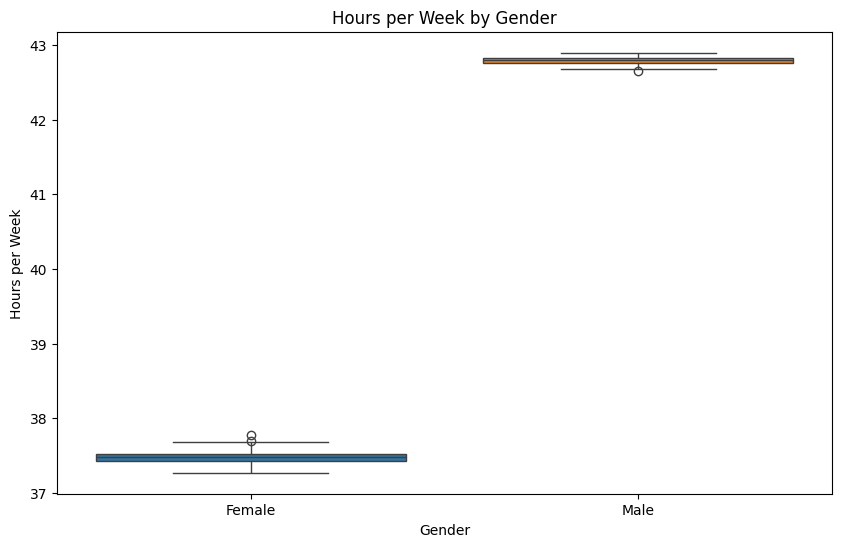

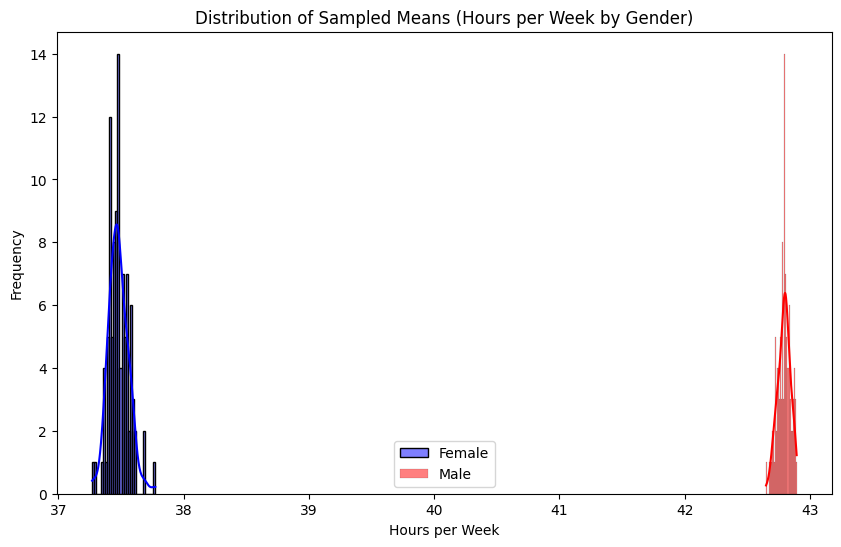

In [66]:
mean_std_df = sampled_means_df.agg(['mean', 'std'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=sampled_means_df)
plt.title('Hours per Week by Gender')
plt.xlabel('Gender')
plt.ylabel('Hours per Week')
plt.savefig('e1_eps1.pdf')

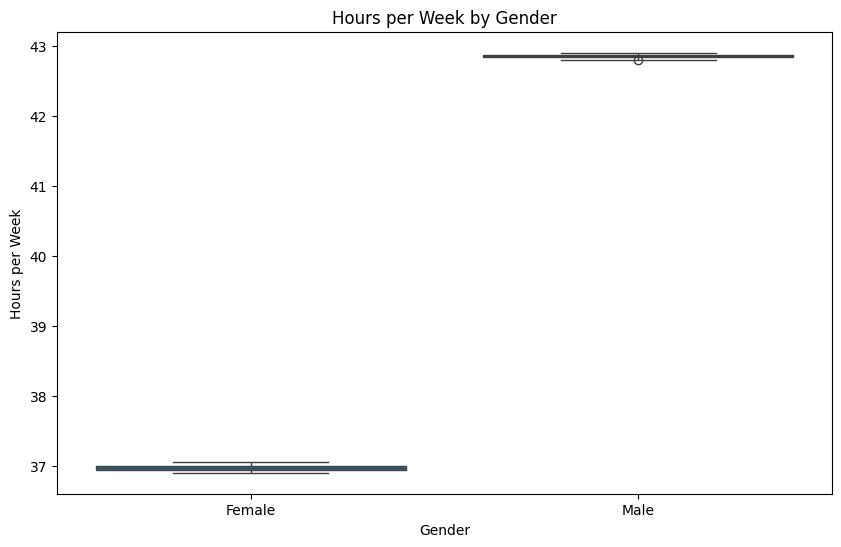

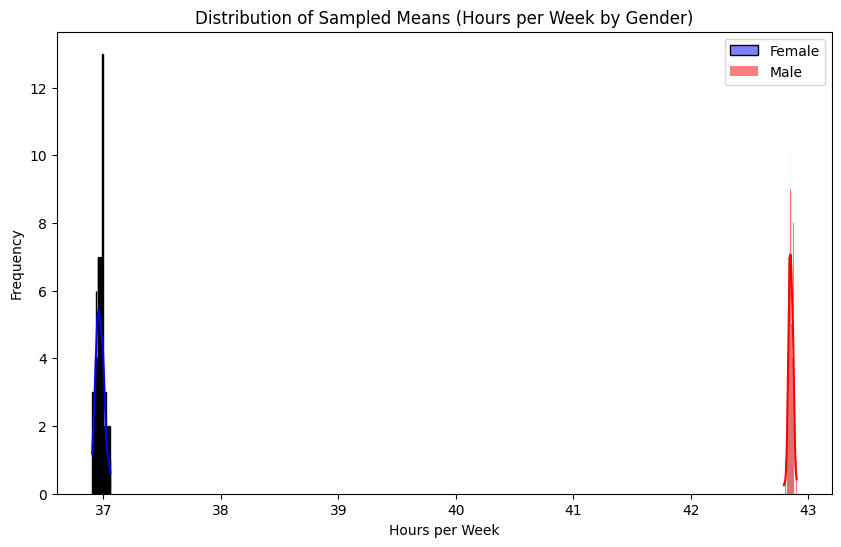

In [65]:
mean_std_df = sampled_means_100_df.agg(['mean', 'std'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=sampled_means_100_df)
plt.title('Hours per Week by Gender') 
plt.xlabel('Gender')
plt.ylabel('Hours per Week')
plt.savefig('e1_eps100.pdf')

# Plot the distribution of the sampled means
plt.figure(figsize=(10, 6))
sns.histplot(sampled_means
plt.xlim(41, 43)_100_df['Female'], kde=True, label='Female', color='blue', bins=30)
sns.histplot(sampled_means_100_df['Male'], kde=True, label='Male', color='red', bins=30)
plt.title('Distribution of Sampled Means (Hours per Week by Gender)')
plt.xlabel('Hours per Week')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('distribution_eps100.pdf')
plt.show()

In [75]:
def euclidean_distance(x1, x2, y1, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

x1, y1 = mean_hours_per_week_by_gender['Female'], mean_hours_per_week_by_gender['Male']
x2, y2 = mean_hours_per_week_by_gender_sampled_1['Female'], mean_hours_per_week_by_gender_sampled_1['Male']
x3, y3 = mean_hours_per_week_by_gender_sampled_100['Female'], mean_hours_per_week_by_gender_sampled_100['Male']

print("epsilon = 1 ", euclidean_distance(x1, x2, y1, y2))
print("epsilon = 100 ", euclidean_distance(x1, x3, y1, y3))

epsilon = 1  0.5503326492203524
epsilon = 100  0.037599662697243845


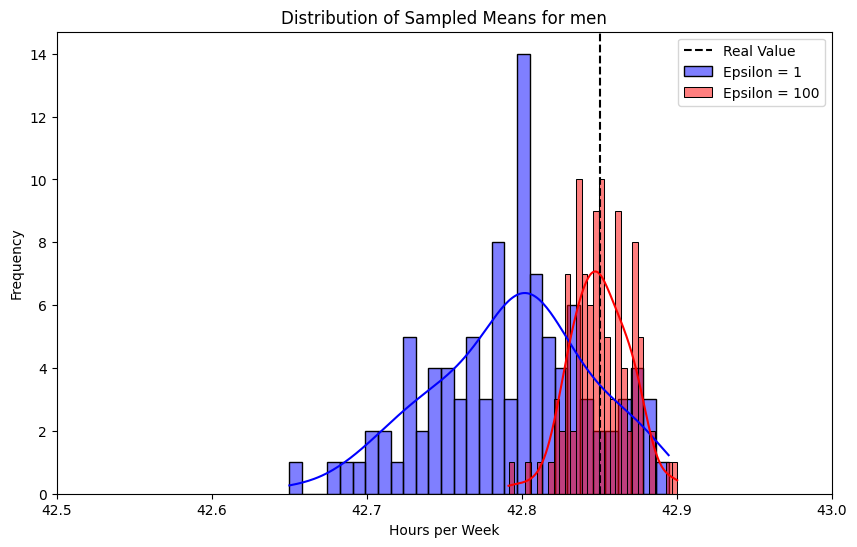

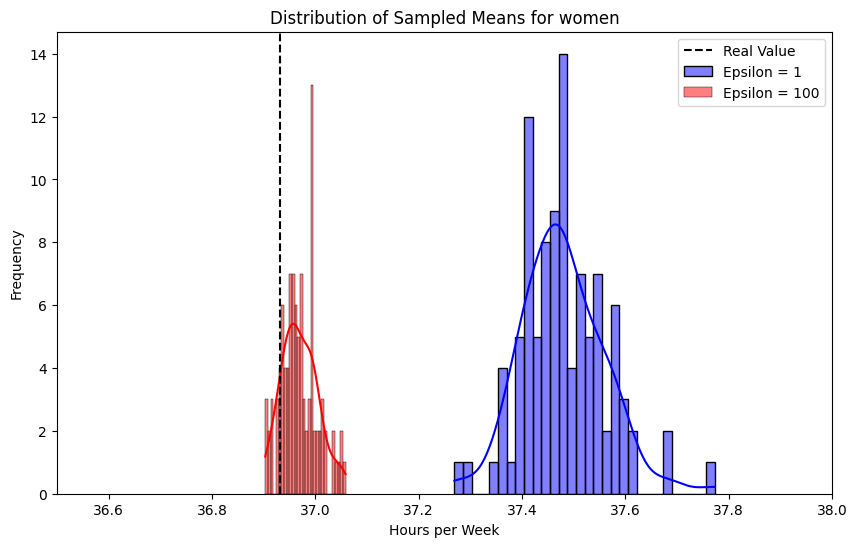

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(sampled_means_df['Male'], kde=True, label='Epsilon = 1', color='blue', bins=30)
sns.histplot(sampled_means_100_df['Male'], kde=True, label='Epsilon = 100', color='red', bins=30)
plt.axvline(x=42.850687, color='black', linestyle='--', label='Real Value')
plt.title('Distribution of Sampled Means for men')
plt.xlabel('Hours per Week')
plt.ylabel('Frequency')
plt.xlim(42.5, 43)
plt.legend()
plt.savefig('distribution_men.pdf')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(sampled_means_df['Female'], kde=True, label='Epsilon = 1', color='blue', bins=30)
sns.histplot(sampled_means_100_df['Female'], kde=True, label='Epsilon = 100', color='red', bins=30)
plt.axvline(x=36.932222, color='black', linestyle='--', label='Real Value')
plt.title('Distribution of Sampled Means for women')
plt.xlabel('Hours per Week')
plt.ylabel('Frequency')
plt.xlim(36.5, 38)
plt.legend()
plt.savefig('distribution_women.pdf')
plt.show()

## Implement Euclidean distance to compare results